## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from scipy import stats


In [2]:
# reproducible random for assigning random floors
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
df = pd.read_csv('clean_variable_all.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Area (in Sq. ft)                4665 non-null   float64
 1   Amount                          4665 non-null   float64
 2   Market Value                    4665 non-null   float64
 3   City                            4665 non-null   object 
 4   Project Name                    4665 non-null   object 
 5   Location                        4665 non-null   object 
 6   Latitude                        4665 non-null   float64
 7   Longitude                       4665 non-null   float64
 8   Sale Type                       4665 non-null   object 
 9   Registration Date               4665 non-null   object 
 10  Quaters                         4665 non-null   object 
 11  YR                              4665 non-null   int64  
 12  Amount in CR                    46

In [9]:
# Log of Amount (dependent variable)
df['log_amount'] = np.log(df['Amount'])
# Option A: keep Area as raw
df['area_raw'] = df['Area (in Sq. ft)']

# Option B: also create log-area (to try log-log model later)
df['log_area'] = np.log(df['Area (in Sq. ft)'])

# Choose predictors
X = df[['log_area', 'Floor_clean', 'SaleType_encoded',
        'bus_stop_count_1km', 'financial_facilities_1km',
        'medical_facilities_1km',
        'distance_to_metro', 'distance_to_railway', 'school_count_1km',
        'kindergarten_count_1km', 'distance_to_supermarket',
        'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
        'park_area_m2', 'waterbody_area_m2',
        'park_leisure_garden', 'park_leisure_park',
       'park_leisure_pitch', 'park_leisure_playground',
       'park_leisure_recreation_common',
       'waterbody_type_lake',
       'waterbody_type_pond', 'waterbody_type_reservoir',
       'waterbody_type_river']]


In [11]:
# Find all boolean columns
bool_cols = X.select_dtypes(include=['bool']).columns
print(bool_cols)
# Convert all boolean columns to integers
X[bool_cols] = X[bool_cols].astype(int)


Index(['park_leisure_garden', 'park_leisure_park', 'park_leisure_pitch',
       'park_leisure_playground', 'park_leisure_recreation_common',
       'waterbody_type_lake', 'waterbody_type_pond',
       'waterbody_type_reservoir', 'waterbody_type_river'],
      dtype='object')


C:\Users\Sayan\AppData\Local\Temp\ipykernel_26800\2290739045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols] = X[bool_cols].astype(int)


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   log_area                        4665 non-null   float64
 1   Floor_clean                     4665 non-null   int64  
 2   SaleType_encoded                4665 non-null   int64  
 3   bus_stop_count_1km              4665 non-null   int64  
 4   financial_facilities_1km        4665 non-null   int64  
 5   medical_facilities_1km          4665 non-null   int64  
 6   distance_to_metro               4665 non-null   float64
 7   distance_to_railway             4665 non-null   float64
 8   school_count_1km                4665 non-null   int64  
 9   kindergarten_count_1km          4665 non-null   int64  
 10  distance_to_supermarket         4665 non-null   float64
 11  distance_to_techhub             4665 non-null   float64
 12  distance_to_park                46

In [15]:
X_1 = X[['log_area', 'Floor_clean', 'SaleType_encoded',
        'bus_stop_count_1km', 'financial_facilities_1km',
        'medical_facilities_1km',
        'distance_to_metro', 'distance_to_railway', 'school_count_1km',
        'kindergarten_count_1km', 'distance_to_supermarket',
        'distance_to_techhub','distance_to_park', 'distance_to_waterbody',
        'park_area_m2', 'waterbody_area_m2'
        ]]

In [17]:
X_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   log_area                  4665 non-null   float64
 1   Floor_clean               4665 non-null   int64  
 2   SaleType_encoded          4665 non-null   int64  
 3   bus_stop_count_1km        4665 non-null   int64  
 4   financial_facilities_1km  4665 non-null   int64  
 5   medical_facilities_1km    4665 non-null   int64  
 6   distance_to_metro         4665 non-null   float64
 7   distance_to_railway       4665 non-null   float64
 8   school_count_1km          4665 non-null   int64  
 9   kindergarten_count_1km    4665 non-null   int64  
 10  distance_to_supermarket   4665 non-null   float64
 11  distance_to_techhub       4665 non-null   float64
 12  distance_to_park          4665 non-null   float64
 13  distance_to_waterbody     4665 non-null   float64
 14  park_are

## OLS model

In [20]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

C:\Users\Sayan\anaconda3\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [21]:
import geopandas as gpd
from libpysal.weights import KNN
from shapely.geometry import Point

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs="EPSG:4326"
)

# Example: k-nearest neighbors (k=8 is common)
w = KNN.from_dataframe(gdf, k=8)
w.transform = "r"  # row-standardized

C:\Users\Sayan\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 35 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [22]:
from spreg import OLS, diagnostics_sp
from esda import Moran
import matplotlib.pyplot as plt

In [23]:
X_1

,log_area,Floor_clean,SaleType_encoded,bus_stop_count_1km,financial_facilities_1km,medical_facilities_1km,distance_to_metro,distance_to_railway,school_count_1km,kindergarten_count_1km,distance_to_supermarket,distance_to_techhub,distance_to_park,distance_to_waterbody,park_area_m2,waterbody_area_m2
0,7.117206,3,0,3,0,1,1021.855251,1031.314063,0,0,1071.728427,5012.910521,205.823897,963.347727,11609.389521,15481.502122
1,7.632401,4,0,7,7,8,1624.793018,1640.439676,2,1,324.707763,1371.896658,215.581180,816.380253,1001.151224,403075.658943
2,7.901007,4,1,7,7,5,2323.930856,2343.893908,7,0,621.209341,2633.436246,560.260318,1138.757111,518.173805,12577.559117
3,7.306531,4,0,8,12,6,71.024054,87.654521,6,1,144.297691,562.039276,128.222356,671.607186,147.420732,25026.590223
4,7.841886,20,0,2,0,0,1789.025763,1805.479717,4,0,1653.838238,3822.477586,70.367519,1359.177291,640.230205,163020.728866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4660,7.801391,16,0,12,6,1,7410.102912,2553.008614,4,0,1256.031510,879.973099,238.373796,508.605424,859.862494,383.302762
4661,7.829233,26,0,12,6,1,7410.102912,2553.008614,4,0,1256.031510,879.973099,238.373796,508.605424,859.862494,383.302762
4662,6.806829,9,0,9,11,6,832.198921,853.351181,3,0,386.751500,768.605871,157.895705,1122.355482,503.926172,28561.029058
4663,7.254178,0,0,9,11,6,832.198921,853.351181,3,0,386.751500,768.605871,157.895705,1122.355482,503.926172,28561.029058


In [24]:
# Dependent variable
y = df['log_amount'].values.reshape(-1, 1)

In [25]:
# Run OLS (you've already defined y, X, and w)
ols_model = OLS(y, X, w=w, name_y='log_amount')

# Print full summary
print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          26
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4639
R-squared           :      0.2534
Adjusted R-squared  :      0.2494
Sum squared residual:     995.964                F-statistic           :     62.9959
Sigma-square        :       0.215                Prob(F-statistic)     :  1.966e-271
S.E. of regression  :       0.463                Log likelihood        :   -3017.661
Sigma-square ML     :       0.213                Akaike info criterion :    6087.321
S.E of regression ML:      0.4621                Schwarz criterion     :    6254.965

------------------------------------------------------------

In [26]:
# Run OLS (you've already defined y, X, and w)
ols_model_1 = OLS(y, X_1, w=w, name_y='log_amount')

# Print full summary
print(ols_model_1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          17
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4648
R-squared           :      0.2428
Adjusted R-squared  :      0.2402
Sum squared residual:     1010.13                F-statistic           :     93.1645
Sigma-square        :       0.217                Prob(F-statistic)     :  6.541e-266
S.E. of regression  :       0.466                Log likelihood        :   -3050.606
Sigma-square ML     :       0.217                Akaike info criterion :    6135.212
S.E of regression ML:      0.4653                Schwarz criterion     :    6244.825

------------------------------------------------------------

In [27]:
'''
X_2 = X_1[['log_area', 'Floor_clean', 'SaleType_encoded',
        'bus_stop_count_1km', 'financial_facilities_1km',
        'medical_facilities_1km',
        'distance_to_metro', 'distance_to_railway', 'school_count_1km',
        'kindergarten_count_1km', 'distance_to_supermarket',
        'distance_to_techhub']]
'''

"\nX_2 = X_1[['log_area', 'Floor_clean', 'SaleType_encoded',\n        'bus_stop_count_1km', 'financial_facilities_1km',\n        'medical_facilities_1km',\n        'distance_to_metro', 'distance_to_railway', 'school_count_1km',\n        'kindergarten_count_1km', 'distance_to_supermarket',\n        'distance_to_techhub']]\n"

In [28]:
'''
# Run OLS (you've already defined y, X, and w)
ols_model_2 = OLS(y, X_2, w=w, name_y='log_amount')

# Print full summary
print(ols_model_2.summary)
'''

"\n# Run OLS (you've already defined y, X, and w)\nols_model_2 = OLS(y, X_2, w=w, name_y='log_amount')\n\n# Print full summary\nprint(ols_model_2.summary)\n"

## Spatial Autocorrelation

In [39]:
from esda import Moran
import matplotlib.pyplot as plt

In [41]:
residuals = ols_model.u.flatten()  # from your fitted OLS model

In [43]:
mi = Moran(residuals, w)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)  

Moran's I: 0.2751378925229339
p-value: 0.001


In [45]:
from spreg import LMtests


In [47]:
# Assuming ols_model is your fitted OLS model and w is your spatial weights object
lm_tests = LMtests(ols_model, w)

# Accessing the results
print(f"LM Error: {lm_tests.lme[0]:.3f}, p-value: {lm_tests.lme[1]:.3f}")
print(f"LM Lag: {lm_tests.lml[0]:.3f}, p-value: {lm_tests.lml[1]:.3f}")
print(f"Robust LM Error: {lm_tests.rlme[0]:.3f}, p-value: {lm_tests.rlme[1]:.3f}")
print(f"Robust LM Lag: {lm_tests.rlml[0]:.3f}, p-value: {lm_tests.rlml[1]:.3f}")
print(f"LM SARMA: {lm_tests.sarma[0]:.3f}, p-value: {lm_tests.sarma[1]:.3f}")


LM Error: 1624.173, p-value: 0.000
LM Lag: 1394.095, p-value: 0.000
Robust LM Error: 241.437, p-value: 0.000
Robust LM Lag: 11.359, p-value: 0.001
LM SARMA: 1635.532, p-value: 0.000


'''
Step 1: Check significance

All tests have p < 0.05, so spatial dependence exists.

This means your OLS residuals are not independent in space, so a standard OLS is inadequate.

Step 2: Compare robust LM tests

Robust LM Error = 241.437, p = 0.000

Robust LM Lag = 11.359, p = 0.001

Interpretation:

Both robust tests are significant, but Robust LM Error >> Robust LM Lag.

This indicates that the spatial autocorrelation is stronger in the error term than in the dependent variable.

Step 3: Decide next model

Significant Robust LM Error → suggests Spatial Error Model (SEM) is more appropriate.

Significant Robust LM Lag → would suggest Spatial Lag Model (SAR).

Since error is dominant here, start with SEM.

SARMA (joint test) confirms that a spatial model is definitely needed.

✅ Summary / Actionable Recommendation

Your OLS residuals are strongly spatially autocorrelated.

Next step: Fit a Spatial Error Model (SEM) using spreg.GM_Error or spreg.ML_Error.

Optionally, after SEM, you can compare AIC / BIC with SAR to see which fits better.
'''

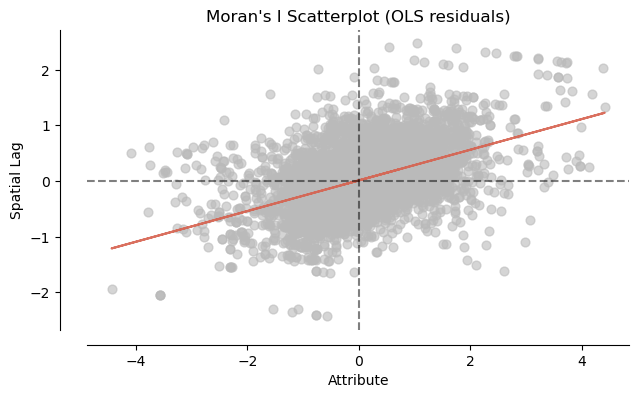

In [50]:
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(mi, aspect_equal=True)
ax.set_title("Moran's I Scatterplot (OLS residuals)")
plt.show()


In [52]:
'''
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot
import os

# Create folder if it doesn't exist
os.makedirs("outputs", exist_ok=True)

# Plot Moran's I
fig, ax = moran_scatterplot(mi, aspect_equal=True)
ax.set_title("Moran's I Scatterplot (OLS residuals)")

# Save figure to 'outputs' folder
fig.savefig("outputs/moran_scatterplot.png", dpi=300, bbox_inches="tight")

plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfrom splot.esda import moran_scatterplot\nimport os\n\n# Create folder if it doesn\'t exist\nos.makedirs("outputs", exist_ok=True)\n\n# Plot Moran\'s I\nfig, ax = moran_scatterplot(mi, aspect_equal=True)\nax.set_title("Moran\'s I Scatterplot (OLS residuals)")\n\n# Save figure to \'outputs\' folder\nfig.savefig("outputs/moran_scatterplot.png", dpi=300, bbox_inches="tight")\n\nplt.show()\n'

### LISA MAP

In [54]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np


In [56]:
from esda import Moran_Local
import numpy as np

# y = variable you used for Moran's I (e.g., OLS residuals)
# w = spatial weights matrix (same as used for Moran's I)

lisa = Moran_Local(y, w)


In [57]:
gdf['local_I'] = lisa.Is
gdf['p_value'] = lisa.p_sim
gdf['quadrant'] = lisa.q
gdf['significant'] = lisa.p_sim < 0.05     # 5% significance


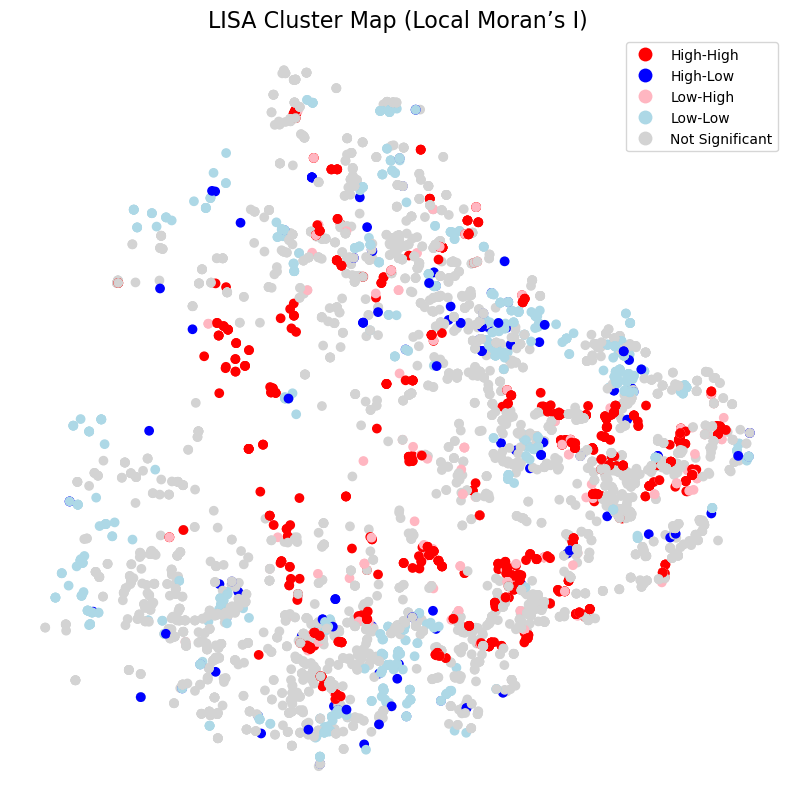

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Only clusters that are statistically significant
sig = gdf['significant']

# Map cluster categories
cluster_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

# Create a color map
cluster_colors = {
    "High-High": "red",
    "Low-Low": "blue",
    "High-Low": "lightpink",
    "Low-High": "lightblue"
}

gdf['cluster_type'] = gdf.apply(
    lambda row: cluster_labels[row['quadrant']] if row['significant'] else "Not Significant",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='cluster_type',
         cmap=colors.ListedColormap(["red","blue","lightpink","lightblue","lightgrey"]),
         legend=True,
         ax=ax)

ax.set_title("LISA Cluster Map (Local Moran’s I)", fontsize=16)
ax.axis("off")

plt.show()


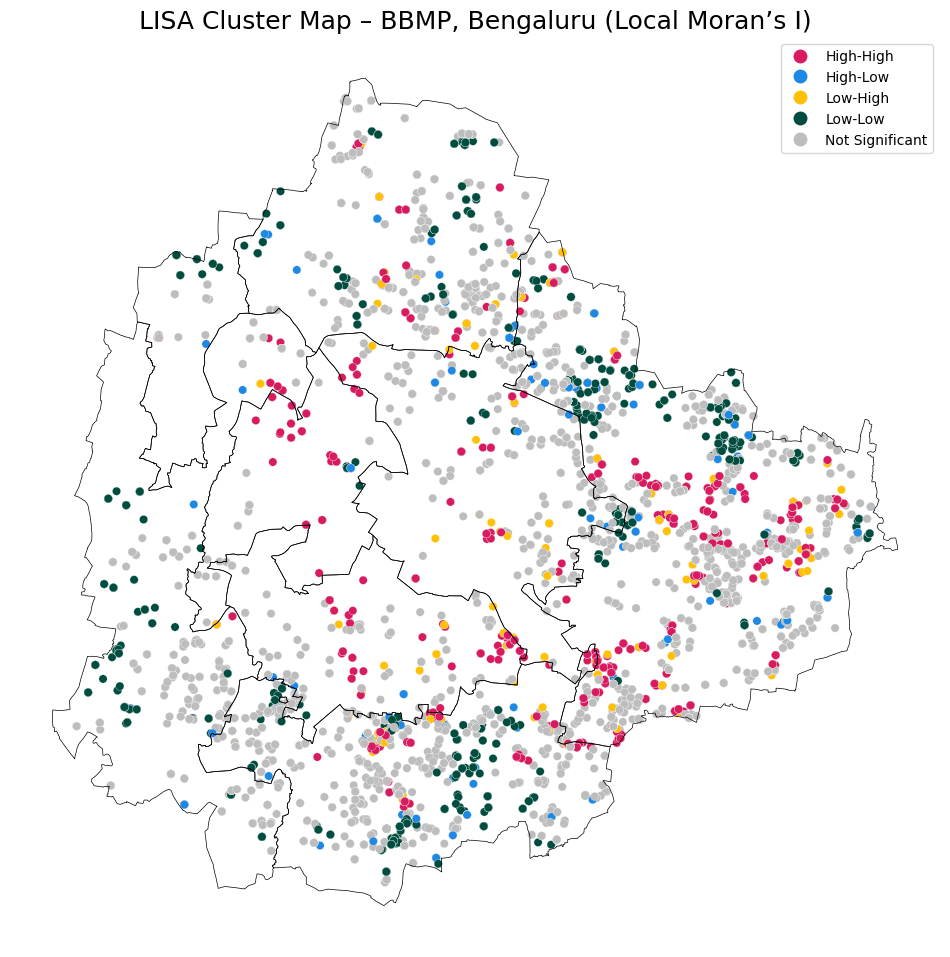

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ----------------------------------------------------------
# 1. LOAD DATA
# ----------------------------------------------------------
# Your housing GDF (already includes LISA results)
# gdf = ...

# Load BBMP boundary shapefile
bbmp = gpd.read_file("BBMP_shape.shp")

# ----------------------------------------------------------
# 2. PROJECT BOTH LAYERS (recommended: Web Mercator 3857)
# ----------------------------------------------------------
gdf_web = gdf.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# ----------------------------------------------------------
# 3. MAP LISA CLUSTERS (color-blind friendly palette)
# ----------------------------------------------------------
cluster_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

# Add cluster type with significance filter
gdf_web["cluster_type"] = gdf_web.apply(
    lambda row: cluster_labels[row["quadrant"]] if row["significant"] else "Not Significant",
    axis=1
)

# Colour-blind friendly palette ("Tol palette")
cluster_palette = {
    "High-High": "#D81B60",      # reddish-pink
    "Low-Low": "#1E88E5",        # strong blue
    "High-Low": "#FFC107",       # yellow
    "Low-High": "#004D40",       # dark teal
    "Not Significant": "#BDBDBD" # grey
}

# Manual colormap
cmap = colors.ListedColormap(list(cluster_palette.values()))
norm = colors.ListedColormap

# ----------------------------------------------------------
# 4. CREATE FIGURE
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 12))

# Plot BBMP boundary first
bbmp_web.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Plot LISA clusters
gdf_web.plot(
    column="cluster_type",
    ax=ax,
    categorical=True,
    legend=True,
    linewidth=0.2,
    edgecolor="white",
    cmap=colors.ListedColormap([cluster_palette[k] for k in cluster_palette.keys()])
)

# ----------------------------------------------------------
# 5. STYLING
# ----------------------------------------------------------
ax.set_title("LISA Cluster Map – BBMP, Bengaluru (Local Moran’s I)", fontsize=18)
ax.axis("off")

plt.show()

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx

# ----------------------------------------------------------
# 1. LOAD DATA
# ----------------------------------------------------------
# Your spatial data frame with LISA results:
# gdf = ...

# BBMP boundary
bbmp = gpd.read_file("BBMP_shape.shp")

# ----------------------------------------------------------
# 2. PROJECT EVERYTHING TO WEB MERCATOR 3857
# ----------------------------------------------------------
gdf_web = gdf.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# ----------------------------------------------------------
# 3. CLASSIFY CLUSTERS
# ----------------------------------------------------------
cluster_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

# Assign cluster types only for significant observations
gdf_web["cluster_type"] = gdf_web.apply(
    lambda row: cluster_labels[row["quadrant"]] if row["significant"] else "Not Significant",
    axis=1
)

# Colour-blind friendly palette
cluster_palette = {
    "High-High": "#D81B60",      # reddish-pink
    "Low-Low": "#1E88E5",        # blue
    "High-Low": "#FFC107",       # yellow
    "Low-High": "#004D40",       # dark teal
    "Not Significant": "#BDBDBD" # neutral grey
}

# ----------------------------------------------------------
# 4. PLOT FIGURE
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 13))

# 4A. Add basemap FIRST
# (Empty plot so basemap draws below everything)
bbmp_web.to_crs(epsg=3857).plot(ax=ax, alpha=0)  # invisible placeholder to set extent

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

# 4B. Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color="black", linewidth=0.7)

# 4C. Plot LISA clusters
gdf_web.plot(
    column="cluster_type",
    ax=ax,
    legend=True,
    categorical=True,
    linewidth=0.3,
    edgecolor="white",
    cmap=colors.ListedColormap([cluster_palette[c] for c in cluster_palette])
)

# ----------------------------------------------------------
# 5. STYLING
# ----------------------------------------------------------
ax.set_title("LISA Cluster Map – BBMP, Bengaluru (Local Moran’s I)", fontsize=18)
ax.axis("off")

# ----------------------------------------------------------
# 6. SAVE HIGH-RES OUTPUT
# ----------------------------------------------------------
output_path = "outputs/lisa_cluster_bbmp_osm.png"
plt.savefig(output_path, dpi=600, bbox_inches="tight")
plt.close()

print(f"✅ LISA map with OSM basemap saved → {output_path}")

✅ LISA map with OSM basemap saved → outputs/lisa_cluster_bbmp_osm.png


## SEM model results

In [54]:
from spreg import ML_Error

# --- Spatial Error Model ---
sem_model = ML_Error(y, X, w=w, name_y='log_amount')

# --- Summary ---
print(sem_model.summary)


C:\Users\Sayan\anaconda3\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          26
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.2463
Log likelihood      :  -2586.5186
Sigma-square ML     :      0.1695                Akaike info criterion :    5225.037
S.E of regression   :      0.4117                Schwarz criterion     :    5392.681

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        13.06960    

In [55]:
from spreg import ML_Error

# --- Spatial Error Model ---
sem_model_1 = ML_Error(y, X_1, w=w, name_y='log_amount')

# --- Summary ---
print(sem_model_1.summary)


C:\Users\Sayan\anaconda3\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          17
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4648
Pseudo R-squared    :      0.2367
Log likelihood      :  -2597.6105
Sigma-square ML     :      0.1700                Akaike info criterion :    5229.221
S.E of regression   :      0.4124                Schwarz criterion     :    5338.834

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        12.54911    

## SLM model

In [58]:
from spreg import ML_Lag

# --- Spatial Lag Model ---
slm_model = ML_Lag(y, X, w=w, name_y='log_amount')

# --- Summary ---
print(slm_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          27
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4638
Pseudo R-squared    :      0.3947
Spatial Pseudo R-squared:  0.2422
Log likelihood      :  -2619.6914
Sigma-square ML     :      0.1737                Akaike info criterion :    5293.383
S.E of regression   :      0.4168                Schwarz criterion     :    5467.475

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

### MWTP

In [74]:
import numpy as np
import matplotlib.pyplot as plt

rho = slm_model.rho
betas = slm_model.betas.flatten()
var_names = slm_model.name_x

# Correct variable
dist_var = 'distance_to_park'
dist_idx = var_names.index(dist_var)
beta_dist = betas[dist_idx]

print("Beta (distance_to_park):", beta_dist)
print("Rho:", rho)


Beta (distance_to_park): -0.00021712718692317324
Rho: 0.5243232105548222


In [76]:
total_impact_dist = beta_dist / (1 - rho)
print("Average total impact (log form):", total_impact_dist)


Average total impact (log form): -0.00045645949464220674


In [78]:
# Mean house price (levels)
mean_price = np.exp(y).mean()

# MWTP per meter
mwtp_per_meter = mean_price * total_impact_dist

print("MWTP per meter:", mwtp_per_meter)


MWTP per meter: -3700.209518288829


In [80]:
distance = np.linspace(0, 1000, 200)

mwtp_distance = mwtp_per_meter * (1 - distance / 1000)
mwtp_distance[mwtp_distance < 0] = 0


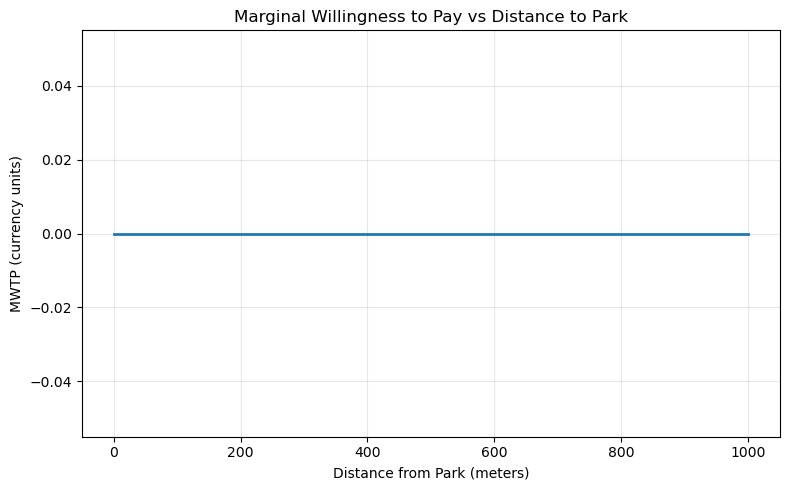

In [82]:
plt.figure(figsize=(8,5))
plt.plot(distance, mwtp_distance, linewidth=2)

plt.xlabel("Distance from Park (meters)")
plt.ylabel("MWTP (currency units)")
plt.title("Marginal Willingness to Pay vs Distance to Park")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [84]:
import numpy as np
import matplotlib.pyplot as plt

distance = np.linspace(0, 1000, 200)  # 0–1000 meters


In [86]:
beta_ols = -0.00038
beta_sem = -0.00036
beta_sar = -0.00022   # direct effect, as reported


In [88]:
pct_ols = (np.exp(beta_ols * distance) - 1) * 100
pct_sem = (np.exp(beta_sem * distance) - 1) * 100
pct_sar = (np.exp(beta_sar * distance) - 1) * 100


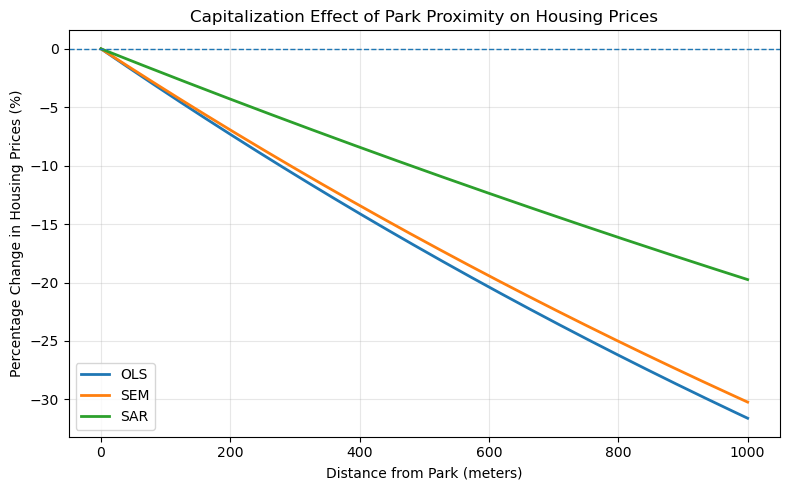

In [91]:
plt.figure(figsize=(8,5))

plt.plot(distance, pct_ols, label='OLS', linewidth=2)
plt.plot(distance, pct_sem, label='SEM', linewidth=2)
plt.plot(distance, pct_sar, label='SAR', linewidth=2)

plt.xlabel('Distance from Park (meters)')
plt.ylabel('Percentage Change in Housing Prices (%)')
plt.title('Capitalization Effect of Park Proximity on Housing Prices')

plt.axhline(0, linestyle='--', linewidth=1)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### t-test of the direct indirect effect

In [101]:
# -------------------------------
# MODEL OBJECTS
# -------------------------------
betas = slm_model.betas.flatten()
vcov = slm_model.vm

# number of slope coefficients actually estimated
n_slopes = len(betas) - 2   # constant + rho removed

# align variable names to betas
X_names = slm_model.name_x[1:1 + n_slopes]
k = n_slopes

w_obj = w

# -------------------------------
# STORAGE
# -------------------------------
direct_sim = np.zeros((n_sim, k))
indirect_sim = np.zeros((n_sim, k))
total_sim = np.zeros((n_sim, k))

# -------------------------------
# MONTE CARLO SIMULATION
# -------------------------------
beta_sim = np.random.multivariate_normal(
    mean=betas,
    cov=vcov,
    size=n_sim
)

for i in range(n_sim):
    rho_i = beta_sim[i, -1]
    beta_i = beta_sim[i, 1:1 + n_slopes]  # slopes only

    mult = spmultiplier(w_obj, rho_i, method="simple")

    adi = mult["adi"]
    aii = mult["aii"]
    ati = mult["ati"]

    direct_sim[i, :] = beta_i * adi
    indirect_sim[i, :] = beta_i * aii
    total_sim[i, :] = beta_i * ati


In [103]:
from scipy import stats
import pandas as pd

def impact_stats(sim):
    mean = sim.mean(axis=0)
    se = sim.std(axis=0)
    z = mean / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return mean, se, z, p

direct = impact_stats(direct_sim)
indirect = impact_stats(indirect_sim)
total = impact_stats(total_sim)


In [106]:
impact_table = pd.DataFrame({
    "Variable": X_names,

    "Direct_Effect": direct[0],
    "Direct_t": direct[2],
    "Direct_p": direct[3],

    "Indirect_Effect": indirect[0],
    "Indirect_t": indirect[2],
    "Indirect_p": indirect[3],

    "Total_Effect": total[0],
    "Total_t": total[2],
    "Total_p": total[3],
})

impact_table = impact_table.round(4)
print(impact_table)


                          Variable  Direct_Effect  Direct_t  Direct_p  \
0                         log_area         0.4405   28.3587    0.0000   
1                      Floor_clean         0.0000    1.7892    0.0736   
2                 SaleType_encoded        -0.0699   -4.8111    0.0000   
3               bus_stop_count_1km        -0.0008   -0.6601    0.5092   
4         financial_facilities_1km         0.0045    3.8866    0.0001   
5           medical_facilities_1km        -0.0017   -1.6871    0.0916   
6                distance_to_metro        -0.0000   -1.2141    0.2247   
7              distance_to_railway        -0.0000   -2.3698    0.0178   
8                 school_count_1km        -0.0046   -2.6496    0.0081   
9           kindergarten_count_1km         0.0029    0.9711    0.3315   
10         distance_to_supermarket         0.0000    0.5862    0.5577   
11             distance_to_techhub        -0.0000   -1.3915    0.1641   
12                distance_to_park        -0.0002  

In [108]:
print(impact_table.to_latex(
    index=False,
    float_format="%.4f",
    caption="Direct, Indirect, and Total Impacts from the Spatial Lag Model",
    label="tab:slm_impacts"
))


\begin{table}
\caption{Direct, Indirect, and Total Impacts from the Spatial Lag Model}
\label{tab:slm_impacts}
\begin{tabular}{lrrrrrrrrr}
\toprule
Variable & Direct_Effect & Direct_t & Direct_p & Indirect_Effect & Indirect_t & Indirect_p & Total_Effect & Total_t & Total_p \\
\midrule
log_area & 0.4405 & 28.3587 & 0.0000 & 0.4846 & 14.6891 & 0.0000 & 0.9251 & 22.5184 & 0.0000 \\
Floor_clean & 0.0000 & 1.7892 & 0.0736 & 0.0000 & 1.7711 & 0.0765 & 0.0000 & 1.7838 & 0.0745 \\
SaleType_encoded & -0.0699 & -4.8111 & 0.0000 & -0.0769 & -4.6740 & 0.0000 & -0.1468 & -4.7990 & 0.0000 \\
bus_stop_count_1km & -0.0008 & -0.6601 & 0.5092 & -0.0009 & -0.6591 & 0.5099 & -0.0017 & -0.6600 & 0.5092 \\
financial_facilities_1km & 0.0045 & 3.8866 & 0.0001 & 0.0049 & 3.8586 & 0.0001 & 0.0094 & 3.9041 & 0.0001 \\
medical_facilities_1km & -0.0017 & -1.6871 & 0.0916 & -0.0019 & -1.6872 & 0.0916 & -0.0036 & -1.6904 & 0.0910 \\
distance_to_metro & -0.0000 & -1.2141 & 0.2247 & -0.0000 & -1.2047 & 0.2283 & -0.000

### Other SLM models


In [70]:
from spreg import ML_Lag

# --- Spatial Lag Model ---
slm_model_1 = ML_Lag(y, X_1, w=w, name_y='log_amount')

# --- Summary ---
print(slm_model_1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          18
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4647
Pseudo R-squared    :      0.3922
Spatial Pseudo R-squared:  0.2304
Log likelihood      :  -2633.8689
Sigma-square ML     :      0.1745                Akaike info criterion :    5303.738
S.E of regression   :      0.4177                Schwarz criterion     :    5419.799

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [61]:
from spreg import GM_Combo_Het

# --- SARAR (GMM version) ---
sarar_gmm = GM_Combo_Het(
    y,
    X,
    w=w,
    name_y='log_amount'
)

print(sarar_gmm.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS- GM-COMBO MODEL (HET)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  log_amount                Number of Observations:        4665
Mean dependent var  :     15.7608                Number of Variables   :          27
S.D. dependent var  :      0.5348                Degrees of Freedom    :        4638
Pseudo R-squared    :      0.3339
Spatial Pseudo R-squared:  0.2502
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         9.50360         1.41938         6.69561         0.00000
            lo

In [62]:
import numpy as np

# number of observations
n = sarar_gmm.n  # or len(y)

# number of parameters estimated (intercept + betas + spatial lags)
k = sarar_gmm.k

# residuals
residuals = sarar_gmm.u  # residuals vector

# sum of squared residuals
ssr = np.sum(residuals ** 2)

# pseudo log-likelihood under Gaussian errors
llf = -n/2 * (np.log(2 * np.pi) + 1 + np.log(ssr / n))

# approximate AIC
AIC = -2 * llf + 2 * k

print(f"Approximate AIC (GMM-SARAR): {AIC:.3f}")


Approximate AIC (GMM-SARAR): 5584.546


In [64]:
from esda.moran import Moran
import numpy as np

# Moran's I for residuals
mi_ols  = Moran(ols_model.u, w)
mi_slm  = Moran(slm_model.u, w)
mi_sem  = Moran(sem_model.u, w)
mi_sarar = Moran(sarar_gmm.u, w)

print("Moran's I of residuals:")
print(f"OLS:   {mi_ols.I:.3f}")
print(f"SLM:   {mi_slm.I:.3f}")
print(f"SEM:   {mi_sem.I:.3f}")
print(f"SARAR: {mi_sarar.I:.3f}")


Moran's I of residuals:
OLS:   0.275
SLM:   0.037
SEM:   0.288
SARAR: 0.175


## GWR

In [21]:
pip install mgwr

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Find all boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns
print(bool_cols)
# Convert all boolean columns to integers
df[bool_cols] = df[bool_cols].astype(int)


Index(['park_leisure_garden', 'park_leisure_park', 'park_leisure_pitch',
       'park_leisure_playground', 'park_leisure_recreation_common',
       'waterbody_type_lake', 'waterbody_type_pond',
       'waterbody_type_reservoir', 'waterbody_type_river'],
      dtype='object')


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Area (in Sq. ft)                4665 non-null   float64
 1   Amount                          4665 non-null   float64
 2   Market Value                    4665 non-null   float64
 3   City                            4665 non-null   object 
 4   Project Name                    4665 non-null   object 
 5   Location                        4665 non-null   object 
 6   Latitude                        4665 non-null   float64
 7   Longitude                       4665 non-null   float64
 8   Sale Type                       4665 non-null   object 
 9   Registration Date               4665 non-null   object 
 10  Quaters                         4665 non-null   object 
 11  YR                              4665 non-null   int64  
 12  Amount in CR                    46

In [27]:
df.columns

Index(['Area (in Sq. ft)', 'Amount', 'Market Value', 'City', 'Project Name',
       'Location', 'Latitude', 'Longitude', 'Sale Type', 'Registration Date',
       'Quaters', 'YR', 'Amount in CR', 'Price Range', 'Project Name main',
       'Rate (Rs/sft)', 'Unit', 'Floor', 'Tower', 'Wing', 'Party 1', 'Party 2',
       'Count', 'bus_stop_count_1km', 'financial_facilities_1km',
       'medical_facilities_1km', 'hospital_facilities_1km',
       'distance_to_metro', 'distance_to_railway', 'school_count_1km',
       'kindergarten_count_1km', 'distance_to_supermarket',
       'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
       'park_name', 'park_area_m2', 'park_lat', 'park_lon', 'waterbody_name',
       'waterbody_waterbody_type_clean', 'waterbody_area_m2', 'waterbody_lat',
       'waterbody_lon', 'Floor_clean', 'SaleType_encoded',
       'park_leisure_garden', 'park_leisure_park', 'park_leisure_pitch',
       'park_leisure_playground', 'park_leisure_recreation_common',


In [29]:
# Drop 
df_dropped = df.drop(['Area (in Sq. ft)', 'Amount', 'Market Value', 'City', 'Project Name',
       'Location', 'Sale Type', 'Registration Date','hospital_facilities_1km',
       'Quaters', 'YR', 'Amount in CR', 'Price Range', 'Project Name main',
       'Rate (Rs/sft)', 'Unit', 'Floor', 'Tower', 'Wing', 'Party 1', 'Party 2',
       'Count','park_lat', 'park_lon', 'waterbody_name','park_name','waterbody_waterbody_type_clean', 'waterbody_lat',
       'waterbody_lon',], axis=1) # axis=1 specifies that we are dropping a column

In [31]:
df_dropped.columns

Index(['Latitude', 'Longitude', 'bus_stop_count_1km',
       'financial_facilities_1km', 'medical_facilities_1km',
       'distance_to_metro', 'distance_to_railway', 'school_count_1km',
       'kindergarten_count_1km', 'distance_to_supermarket',
       'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
       'park_area_m2', 'waterbody_area_m2', 'Floor_clean', 'SaleType_encoded',
       'park_leisure_garden', 'park_leisure_park', 'park_leisure_pitch',
       'park_leisure_playground', 'park_leisure_recreation_common',
       'waterbody_type_lake', 'waterbody_type_pond',
       'waterbody_type_reservoir', 'waterbody_type_river', 'log_amount',
       'area_raw', 'log_area'],
      dtype='object')

In [33]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        4665 non-null   float64
 1   Longitude                       4665 non-null   float64
 2   bus_stop_count_1km              4665 non-null   int64  
 3   financial_facilities_1km        4665 non-null   int64  
 4   medical_facilities_1km          4665 non-null   int64  
 5   distance_to_metro               4665 non-null   float64
 6   distance_to_railway             4665 non-null   float64
 7   school_count_1km                4665 non-null   int64  
 8   kindergarten_count_1km          4665 non-null   int64  
 9   distance_to_supermarket         4665 non-null   float64
 10  distance_to_techhub             4665 non-null   float64
 11  distance_to_park                4665 non-null   float64
 12  distance_to_waterbody           46

In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap

# --- Step 1: Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(
    df_dropped,
    geometry=gpd.points_from_xy(df_dropped['Longitude'], df_dropped['Latitude']),
    crs='EPSG:4326'
)

# --- Step 2: Project to UTM (Bangalore ≈ EPSG:32643) ---
gdf_proj = gdf.to_crs(epsg=32643)

# --- Step 3: Define dependent and independent variables ---
y_var = 'log_amount'
X_vars = [
    'bus_stop_count_1km', 'financial_facilities_1km', 'medical_facilities_1km', 'distance_to_metro', 'distance_to_railway',
    'school_count_1km', 'kindergarten_count_1km', 'distance_to_supermarket',
    'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
    'park_area_m2', 'waterbody_area_m2', 'Floor_clean', 'SaleType_encoded',
    'park_leisure_garden', 'park_leisure_park',
       'park_leisure_pitch', 'park_leisure_playground',
       'park_leisure_recreation_common',
       'waterbody_type_lake',
       'waterbody_type_pond', 'waterbody_type_reservoir',
       'waterbody_type_river', 'area_raw', 'log_area'
]

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_df = gdf_proj[X_vars].copy()

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

vif_data.sort_values("VIF", ascending=False)

,feature,VIF
25,log_area,349.771278
20,waterbody_type_lake,144.649901
21,waterbody_type_pond,51.974327
22,waterbody_type_reservoir,28.310408
24,area_raw,25.577184
23,waterbody_type_river,8.556582
1,financial_facilities_1km,7.189323
4,distance_to_railway,5.851528
2,medical_facilities_1km,5.672754
0,bus_stop_count_1km,5.400138


In [39]:
X_df.columns


Index(['bus_stop_count_1km', 'financial_facilities_1km',
       'medical_facilities_1km', 'distance_to_metro', 'distance_to_railway',
       'school_count_1km', 'kindergarten_count_1km', 'distance_to_supermarket',
       'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
       'park_area_m2', 'waterbody_area_m2', 'Floor_clean', 'SaleType_encoded',
       'park_leisure_garden', 'park_leisure_park', 'park_leisure_pitch',
       'park_leisure_playground', 'park_leisure_recreation_common',
       'waterbody_type_lake', 'waterbody_type_pond',
       'waterbody_type_reservoir', 'waterbody_type_river', 'area_raw',
       'log_area'],
      dtype='object')

In [41]:
X_vars_gwr = [
       'financial_facilities_1km', 'medical_facilities_1km', 'distance_to_railway',
       'school_count_1km', 'kindergarten_count_1km',
       'distance_to_techhub', 'distance_to_park', 'distance_to_waterbody',
       'park_area_m2', 'Floor_clean', 'SaleType_encoded', 'log_area'
]


In [43]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import numpy as np


In [45]:

# --- Prepare Variables ---
y = np.array(gdf_proj[y_var]).reshape((-1, 1))
X = np.array(gdf_proj[X_vars_gwr])
coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))

print(f"Data ready: {X.shape[0]} observations, {X.shape[1]} predictors")

# --- Step 1: Bandwidth Selection ---
bw = Sel_BW(coords, y, X, fixed=True, kernel='gaussian').search()
print(f"\n✅ Optimal Bandwidth: {bw:.2f}")

# --- Step 2: Fit GWR (with variable names included) ---
gwr_model = GWR(
    coords,
    y,
    X,
    bw,
    fixed=True,
    kernel='gaussian',
    constant=True,
    name_x=X_vars_gwr
).fit()

# --- Step 3: Print Model Summary ---
print("\n=========== GWR Summary with Variable Names ===========")
print(gwr_model.summary())

Data ready: 4665 observations, 12 predictors

✅ Optimal Bandwidth: 652.29

=========== GWR Summary with Variable Names ===========
Model type                                                         Gaussian
Number of observations:                                                4665
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1010.221
Log-likelihood:                                                   -3050.813
AIC:                                                               6127.626
AICc:                                                              6129.716
BIC:                                                             -38289.145
R2:                                                                   0.243
Adj. R2:                                                              0.241

Varia

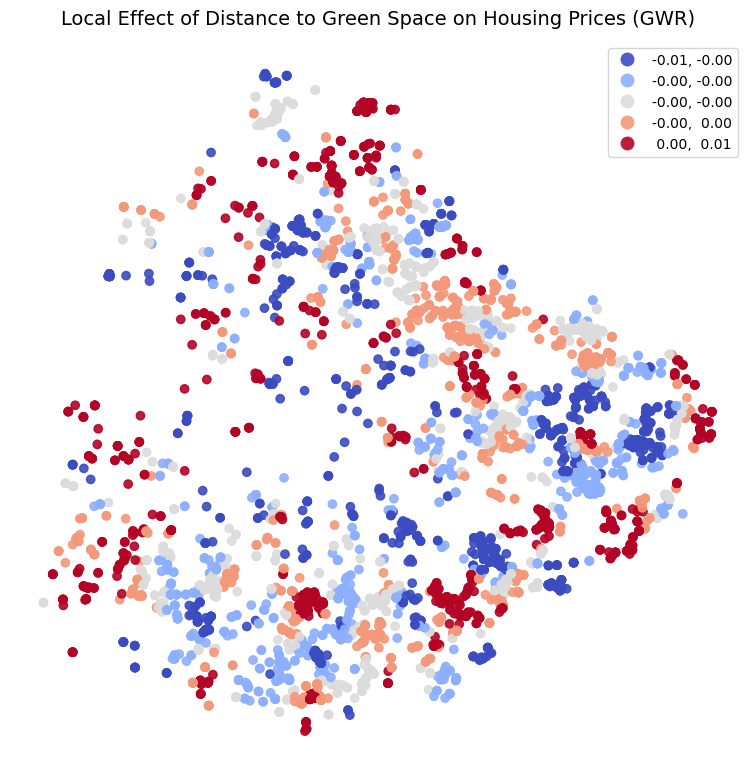

In [47]:
import matplotlib.pyplot as plt
import geopandas as gpd

# --- Step 1: Add GWR coefficients to GeoDataFrame ---
# Add 'Intercept' manually since gwr_model itself doesn't store that flag
var_names = ['Intercept'] + X_vars_gwr if gwr_model.params.shape[1] == len(X_vars_gwr) + 1 else X_vars_gwr

for i, var in enumerate(var_names):
    gdf_proj[f'{var}_coef'] = gwr_model.params[:, i]

# --- Step 2: Select the variable to visualize ---
var_to_plot = 'distance_to_park_coef'  # adjust if your variable name differs

# --- Step 3: Plot heatmap of local coefficients ---
fig, ax = plt.subplots(figsize=(10, 8))

gdf_proj.plot(
    column=var_to_plot,
    cmap='coolwarm',
    legend=True,
    scheme='quantiles',
    k=5,
    alpha=0.9,
    ax=ax
)

ax.set_title("Local Effect of Distance to Green Space on Housing Prices (GWR)",
             fontsize=14, pad=12)
ax.axis('off')

plt.tight_layout()
plt.show()


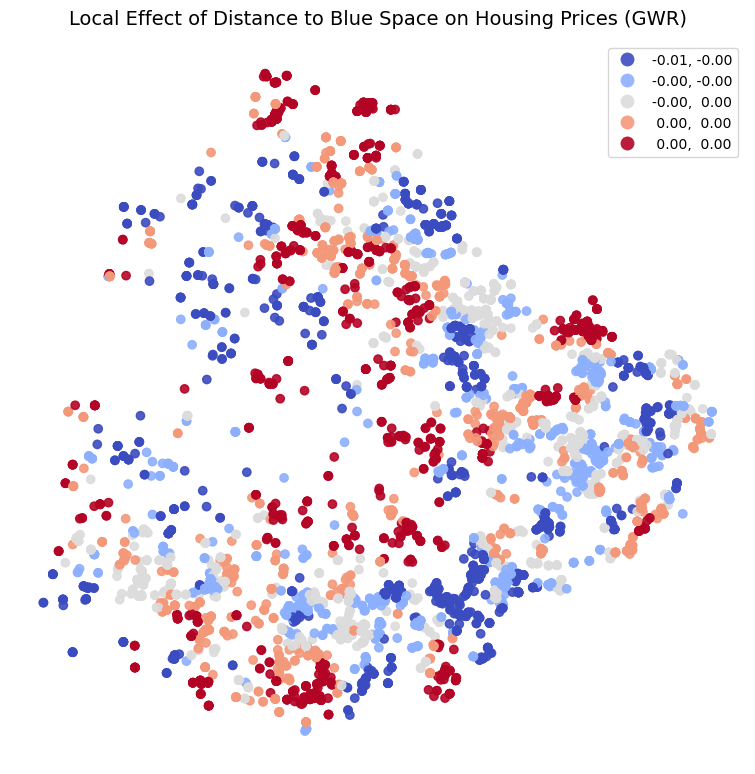

In [49]:
# --- Step 1: Add GWR coefficients to GeoDataFrame ---
# Add 'Intercept' manually since gwr_model itself doesn't store that flag
var_names = ['Intercept'] + X_vars_gwr if gwr_model.params.shape[1] == len(X_vars_gwr) + 1 else X_vars_gwr

for i, var in enumerate(var_names):
    gdf_proj[f'{var}_coef'] = gwr_model.params[:, i]

# --- Step 2: Select the variable to visualize ---
var_to_plot = 'distance_to_waterbody_coef'  # adjust if your variable name differs

# --- Step 3: Plot heatmap of local coefficients ---
fig, ax = plt.subplots(figsize=(10, 8))

gdf_proj.plot(
    column=var_to_plot,
    cmap='coolwarm',
    legend=True,
    scheme='quantiles',
    k=5,
    alpha=0.9,
    ax=ax
)

ax.set_title("Local Effect of Distance to Blue Space on Housing Prices (GWR)",
             fontsize=14, pad=12)
ax.axis('off')

plt.tight_layout()
plt.show()

In [133]:


# Load BBMP wards or zones shapefile
bbmp = gpd.read_file("BBMP_shape.shp")

# Ensure same CRS as your transaction data
bbmp = bbmp.to_crs(gdf_proj.crs)


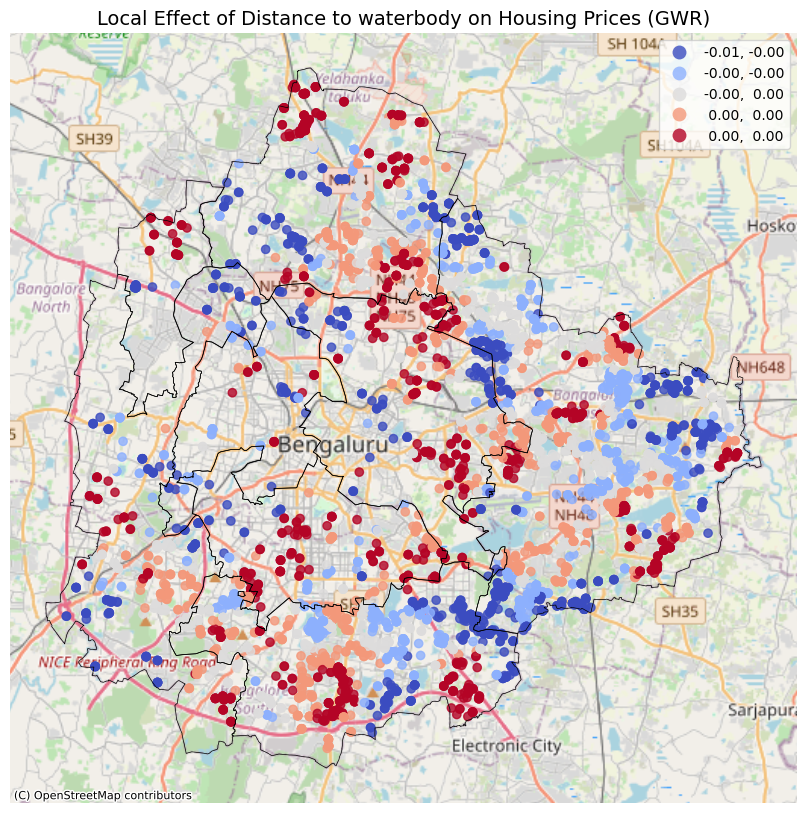

In [139]:
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd

# --- Step 1: Add GWR coefficients to GeoDataFrame ---
# Add 'Intercept' manually since gwr_model itself doesn't store that flag
var_names = ['Intercept'] + X_vars_gwr if gwr_model.params.shape[1] == len(X_vars_gwr) + 1 else X_vars_gwr

for i, var in enumerate(var_names):
    gdf_proj[f'{var}_coef'] = gwr_model.params[:, i]

# --- Step 2: Select the variable to visualize ---
var_to_plot = 'distance_to_waterbody_coef'  # adjust if your variable name differs

# --- Step 2: Project both datasets to Web Mercator ---
gdf_proj_web = gdf_proj.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# --- Step 3: Plot coefficient map (e.g., distance_to_park) ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot local coefficients (now it exists!)
gdf_proj_web.plot(
    column='distance_to_waterbody_coef',
    cmap='coolwarm',
    legend=True,
    scheme='quantiles',
    k=5,
    alpha=0.8,
    ax=ax
)

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Styling
ax.set_title("Local Effect of Distance to waterbody on Housing Prices (GWR)", fontsize=14)
ax.axis('off')

plt.show()


In [149]:
pip install matplotlib-scalebar


Note: you may need to restart the kernel to use updated packages.


In [153]:
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# Project both datasets to Web Mercator for contextily
gdf_proj_web = gdf_proj.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# Plot coefficient map (e.g., distance_to_park)
fig, ax = plt.subplots(figsize=(12, 10))

# Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot local coefficients
gdf_proj_web.plot(column='distance_to_waterbody_coef',
                  cmap='coolwarm', legend=True,
                  scheme='quantiles', k=5,  # optional classification
                  alpha=0.8, ax=ax)

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# --- Add map elements ---
ax.set_title("Local Effect of Distance to Waterbody on Housing Prices (GWR)", fontsize=16)
ax.axis('off')

# Add north arrow
ax.text(0.95, 0.1, 'N', transform=ax.transAxes, ha='center', va='center',
        fontsize=16, fontweight='bold')
ax.arrow(0.95, 0.12, 0, 0.05, transform=ax.transAxes, color='k',
         head_width=0.02, head_length=0.03)

# Add scale bar (using meters as CRS units)
scalebar = ScaleBar(1, units="m", location='lower left')
ax.add_artist(scalebar)

# --- Save high-resolution image ---
output_path = "outputs/gwr_distance_to_waterbody.png"
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.close()

print(f"✅ Map saved successfully to: {output_path}")

✅ Map saved successfully to: outputs/gwr_distance_to_waterbody.png


In [108]:
pip install matplotlib-scalebar


Note: you may need to restart the kernel to use updated packages.


In [109]:
'''
import os
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# --- Create output folder if it doesn’t exist ---
os.makedirs("outputs", exist_ok=True)

# --- Reproject for web mapping tiles ---
gdf_proj_web = gdf_proj.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot GWR coefficient map (example variable)
gdf_proj_web.plot(
    column='distance_to_park_coef',
    cmap='coolwarm',
    legend=True,
    scheme='quantiles', k=5,
    alpha=0.8,
    ax=ax
)

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# --- Add map elements ---
ax.set_title("Local Effect of Distance to Park on Housing Prices (GWR)", fontsize=16)
ax.axis('off')

# Add north arrow
ax.text(0.95, 0.1, 'N', transform=ax.transAxes, ha='center', va='center',
        fontsize=16, fontweight='bold')
ax.arrow(0.95, 0.12, 0, 0.05, transform=ax.transAxes, color='k',
         head_width=0.02, head_length=0.03)

# Add scale bar (using meters as CRS units)
scalebar = ScaleBar(1, units="m", location='lower left')
ax.add_artist(scalebar)

# --- Save high-resolution image ---
output_path = "outputs/gwr_distance_to_park.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Map saved successfully to: {output_path}")
'''

'\nimport os\nimport contextily as ctx\nimport matplotlib.pyplot as plt\nfrom matplotlib_scalebar.scalebar import ScaleBar\n\n# --- Create output folder if it doesn’t exist ---\nos.makedirs("outputs", exist_ok=True)\n\n# --- Reproject for web mapping tiles ---\ngdf_proj_web = gdf_proj.to_crs(epsg=3857)\nbbmp_web = bbmp.to_crs(epsg=3857)\n\n# --- Plot setup ---\nfig, ax = plt.subplots(figsize=(12, 10))\n\n# Plot BBMP boundary\nbbmp_web.boundary.plot(ax=ax, color=\'black\', linewidth=0.5)\n\n# Plot GWR coefficient map (example variable)\ngdf_proj_web.plot(\n    column=\'distance_to_park_coef\',\n    cmap=\'coolwarm\',\n    legend=True,\n    scheme=\'quantiles\', k=5,\n    alpha=0.8,\n    ax=ax\n)\n\n# Add OSM basemap\nctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)\n\n# --- Add map elements ---\nax.set_title("Local Effect of Distance to Park on Housing Prices (GWR)", fontsize=16)\nax.axis(\'off\')\n\n# Add north arrow\nax.text(0.95, 0.1, \'N\', transform=ax.transAxes, ha=\'cen

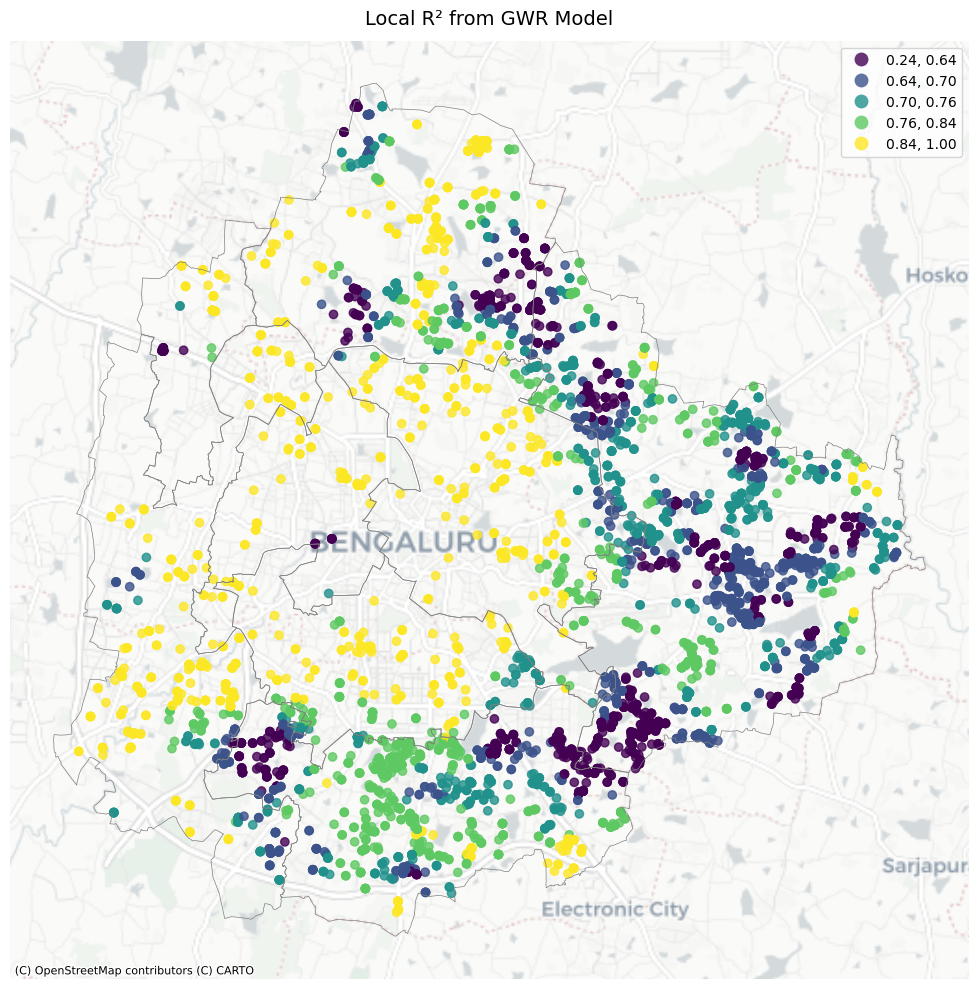

In [110]:
# --- Step 1: Add local R² values to your GeoDataFrame ---
# gwr_model.localR2 gives an array of local R² for each observation
gdf_proj['local_R2'] = gwr_model.localR2

# --- Step 2: Project both datasets to Web Mercator ---
gdf_proj_web = gdf_proj.to_crs(epsg=3857)
bbmp_web = bbmp.to_crs(epsg=3857)

# --- Step 3: Plot Local R² map ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color='grey', linewidth=0.5)

# Plot local R²
gdf_proj_web.plot(
    column='local_R2',
    cmap='viridis',
    legend=True,
    alpha=0.8,
    scheme='quantiles',  # optional for clearer breaks
    k=5,
    ax=ax
)

# Add light basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style
ax.set_title("Local R² from GWR Model", fontsize=14, pad=12)
ax.axis('off')

plt.tight_layout()
plt.show()

In [111]:
'''
import os
import contextily as ctx
import matplotlib.pyplot as plt

# --- Create output folder if it doesn’t exist ---
os.makedirs("outputs", exist_ok=True)

# --- Plot Local R² ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot BBMP boundary
bbmp_web.boundary.plot(ax=ax, color='grey', linewidth=0.5)

# Plot local R² values
gdf_proj_web.plot(
    column='local_R2',
    cmap='viridis',
    legend=True,
    alpha=0.8,
    ax=ax
)

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style and title
ax.set_title("Local R² from GWR Model", fontsize=14)
ax.axis('off')

# --- Save image ---
output_path = "outputs/gwr_local_R2_map.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Map saved successfully at: {output_path}")
'''

'\nimport os\nimport contextily as ctx\nimport matplotlib.pyplot as plt\n\n# --- Create output folder if it doesn’t exist ---\nos.makedirs("outputs", exist_ok=True)\n\n# --- Plot Local R² ---\nfig, ax = plt.subplots(figsize=(12, 10))\n\n# Plot BBMP boundary\nbbmp_web.boundary.plot(ax=ax, color=\'grey\', linewidth=0.5)\n\n# Plot local R² values\ngdf_proj_web.plot(\n    column=\'local_R2\',\n    cmap=\'viridis\',\n    legend=True,\n    alpha=0.8,\n    ax=ax\n)\n\n# Add OSM basemap\nctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)\n\n# Style and title\nax.set_title("Local R² from GWR Model", fontsize=14)\nax.axis(\'off\')\n\n# --- Save image ---\noutput_path = "outputs/gwr_local_R2_map.png"\nplt.savefig(output_path, dpi=300, bbox_inches=\'tight\')\nplt.close()\n\nprint(f"✅ Map saved successfully at: {output_path}")\n'

🧮 For comparison — using your spatial models:
Model	Coefficient for distance_to_park	% Change (100 m)	Interpretation
OLS	−0.00038	−3.73 %	Baseline global effect
SEM	−0.00036	−3.53 %	After controlling for spatial error
SLM	−0.00022	−2.18 %	After including spatial lag (spillover dampens the direct effect)
GWR (mean)	roughly −0.000 (varies spatially)	typically between −1 % and −4 %, depending on local context	Spatially varying effects
🧭 Summary Interpretation

The “distance to park” effect is negative and significant in every model → confirms strong amenity value of green proximity.

The effect magnitude shrinks in spatial models, especially SLM, because part of the price premium is spatially autocorrelated (captured by ρ = 0.52).

GWR shows this effect is not uniform — in some neighborhoods, the premium of being near a park can be much stronger (4–5 %), while in others negligible or slightly reversed.

In [1]:
from platform import python_version
print(python_version())

3.12.7
